## Integrated data Kinchen et al. (2018) and Smillie et al. (2019)

In [1]:
%matplotlib inline

In [2]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import warnings
import seaborn as sns
from scipy.signal import find_peaks
import pandas as pd

In [3]:
magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

C:\Users\아이디어패드\AppData\Local\Temp\ipykernel_1428\20741051.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma', 256)


In [4]:
def condition_stacked_bar_plot(adata, cluster, condition, save=''):
    condition_counts = pd.crosstab(adata.obs[cluster], adata.obs[condition])
    condition_counts['pct_HC'] = 100 * condition_counts['HC'] / (condition_counts['HC'] + condition_counts['UC'])
    condition_counts['pct_UC'] = 100 * condition_counts['UC'] / (condition_counts['HC'] + condition_counts['UC'])
    clusters = condition_counts.index
    pct_HC = condition_counts['pct_HC']
    pct_UC = condition_counts['pct_UC']
    plt.figure(figsize=(10, 6))
    plt.bar(clusters, pct_HC, label='Healthy', color='#F7E7CE')
    plt.bar(clusters, pct_UC, bottom=pct_HC, label='IBD', color='#BFD7ED')
    plt.ylabel('Percentage')
    plt.xlabel('Cluster')
    plt.title('Percentage of Healthy vs Disease Cells per Cluster')
    plt.legend()
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    if save != '':
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=cluster, pval_cutoff=None)
    degs = degs.rename(columns={
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [6]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table_with_cluster_column(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=None)
    degs = degs.rename(columns={
        'group': 'group',
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['group', 'gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [47]:
# Kinchen Human mesenchyme
adata1 = sc.read_csv('Human Colonic Mesenchyme(Kinchen., 2018)/GSE114374_Human_UC_expression_matrix.txt.gz', delimiter='\t').T

In [48]:
batch_keys1 = adata1.obs_names.str[-3:]
adata1.obs['batch'] = batch_keys1.values

In [49]:
# Smillie Human stromal
adata2 = sc.read_mtx('Human stromal(smillie., 2019)/gene_sorted-Fib.matrix.mtx').T
genes2 = pd.read_csv('Human stromal(smillie., 2019)/Fib.genes.tsv', header=None, sep='\t')
adata2.var.index = genes2[0].values
barcodes2 = pd.read_csv('Human stromal(smillie., 2019)/Fib.barcodes2.tsv', header=None, sep='\t')
adata2.obs.index = barcodes2[0].values

In [50]:
batch_keys2 = adata2.obs_names.str.split('.').str[:2].str.join('.')
adata2.obs['batch'] = batch_keys2.values

In [51]:
adata1.X = np.expm1(adata1.X)

In [52]:
sc.pp.normalize_total(adata2, target_sum=10000)

In [53]:
adata_combined = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],
                          )

In [54]:
adata_combined.var['mt'] = adata_combined.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    adata_combined,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [55]:
adata_combined = adata_combined[adata_combined.obs['pct_counts_mt']<5]
sc.pp.filter_genes(adata_combined, min_cells=10)
sc.pp.log1p(adata_combined)

C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [56]:
sc.pp.highly_variable_genes(
    adata_combined,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
adata_combined.raw = adata_combined.copy()
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:691: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(
C:\Anaconda3\envs\NIM_Kim\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  d

C:\Anaconda3\envs\NIM_Kim\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


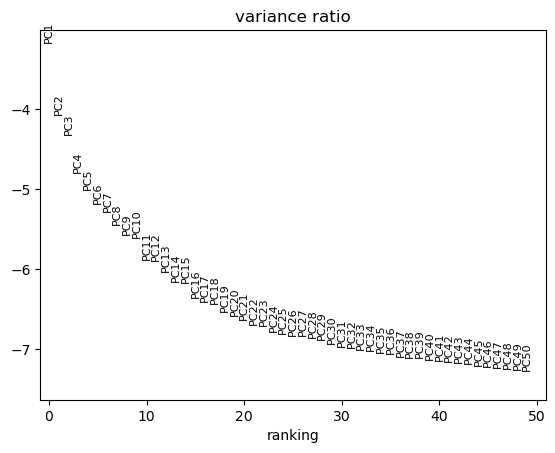

In [57]:
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs = 50)

In [58]:
sc.external.pp.harmony_integrate(adata_combined, key='batch')
sc.pp.neighbors(adata_combined, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined, random_state=1)

2025-07-15 12:17:19,655 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-15 12:17:22,733 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-15 12:17:22,902 - harmonypy - INFO - Iteration 1 of 10
2025-07-15 12:17:38,115 - harmonypy - INFO - Iteration 2 of 10
2025-07-15 12:17:53,667 - harmonypy - INFO - Iteration 3 of 10
2025-07-15 12:18:08,679 - harmonypy - INFO - Iteration 4 of 10
2025-07-15 12:18:23,486 - harmonypy - INFO - Iteration 5 of 10
2025-07-15 12:18:37,036 - harmonypy - INFO - Iteration 6 of 10
2025-07-15 12:18:52,237 - harmonypy - INFO - Iteration 7 of 10
2025-07-15 12:19:03,396 - harmonypy - INFO - Converged after 7 iterations


In [59]:
sc.tl.leiden(adata_combined, resolution=0.6)

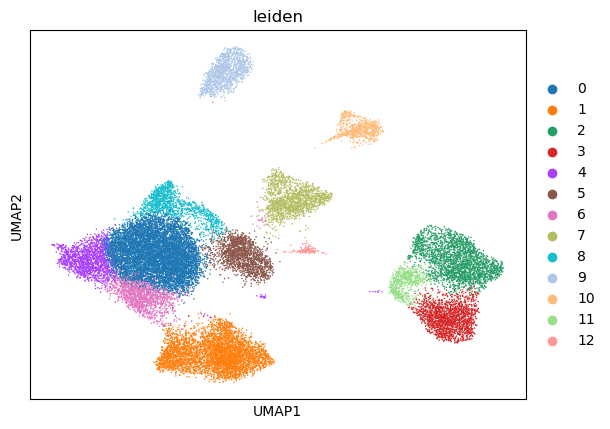

In [60]:
sc.pl.umap(adata_combined,color='leiden')

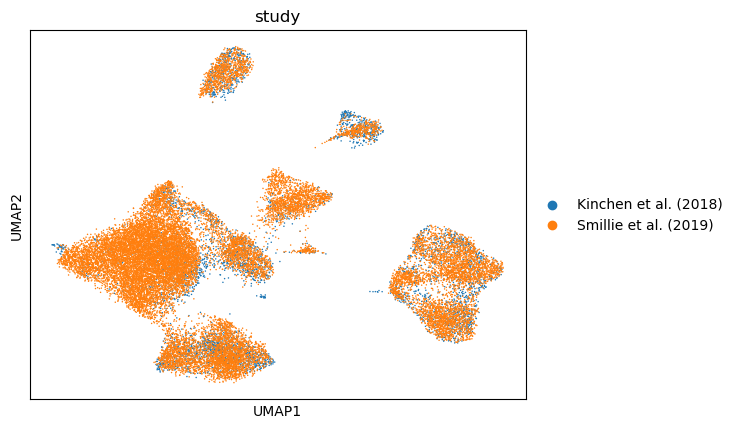

In [61]:
sc.pl.umap(adata_combined, color=['study'], use_raw=True)

condition_stacked_bar_plot(adata_combined, 'celltype', 'condition', save='celltype_condition.png')

In [ ]:
smillie_deg = pd.read_excel('1-s2.0-S0092867419307329-mmc2.xlsx', sheet_name='Stromal')

In [ ]:
marker_genes = {}
for celltype in smillie_deg.loc[:, 'ident'].unique(): 
    marker_genes[celltype] = smillie_deg.loc[smillie_deg['ident'] == celltype, 'gene'].head(5).tolist()

In [ ]:
marker_genes['FOS'] = ['FOS']

In [ ]:
marker_genes['F.Endothelial'] = ['SPOCK1', 'FAM110D', 'RAMP3', 'VWF']
marker_genes['Post-capillary Venules'] = ['CLDN5', 'ZNF385D', 'SELP', 'MADCAM1']

In [ ]:
marker_genes

In [ ]:
sc.pl.dotplot(adata_combined, marker_genes, 'leiden', use_raw=True)

sc.pl.heatmap(adata_combined,  smillie_kinchen_marker_genes, 'celltype', show_gene_labels=True, save='smillie+kinchen_marker_genes.png')

In [ ]:
colon_marker_genes = {
    'glial': ['SOX10', 'PLP1', 'S100B'],
    'pericytes': ['RGS5'],
    'plasma cells': ['SDC1'],
    'stromal 1': ['APOE', 'CCL8', 'FABP5', 'ADAMDEC1'],
    'stromal 2': ['SOX6', 'VSTM2A', 'ID1', 'POSTN'],
    'stromal 3': ['KLF4', 'ID2', 'GREM1', 'OGN'],
    'stromal 4': ['ICAM1', 'IRF8', 'TNFSF13B', 'CCL19', 'IL32', 'C3'],
    'myofibroflasts': ['TAGLN', 'ACTA2', 'FLNA', 'TCEAL1'],
    'pan-fibroflast marker genes': ['VIM', 'COL1A2', 'COL3A1'],
    'IL11 related': ['IL11', 'IL11RA', 'IL6ST']
}

In [ ]:
smillie_kinchen_marker_genes = {
    'Endothelial': ['PLVAP', 'CLDN5', 'SEMA3G', 'RBP7', 'MMRN2'],
 'F.Crypt': ['CCL7', 'CFD', 'SHISA3', 'SFTA1P', 'IGFBP7'],
 'F.Endothelial': ['SPOCK1', 'FAM110D', 'RAMP3', 'VWF'],
 'F.Fibroblast': ['SPOCK1', 'SFTA1P', 'PTGFR', 'ELANE', 'HSD11B1'],
 'F.Stromal': ['FAM110D', 'ZNF385D', 'EHD2', 'TEK', 'NKX2-3'],
 'F.Villus': ['REEP2', 'CBLN2', 'GLP2R', 'VSTM2A', 'ENHO'],
 'Inflammatory Fibroblasts': ['IGFBP7', 'LUM', 'C1S', 'CHI3L1', 'LGALS1'],
 'Microvascular': ['PLVAP', 'IGFBP7', 'GNG11', 'RAMP3', 'VWF'],
 'Myofibroblasts': ['ACTA2', 'ACTG2', 'CNN1', 'MYH11', 'TAGLN'],
 'Pericytes': ['RGS5', 'COX4I2', 'HIGD1B', 'IGFBP7', 'NOTCH3'],
 'Post-capillary Venules': ['CLDN5', 'ZNF385D', 'SELP', 'MADCAM1'],
 'RSPO3+': ['LUM', 'DCN', 'IGFBP7', 'OGN', 'GREM2'],
 'WNT2B+ Fos-hi': ['IGFBP7', 'ADAMDEC1', 'CFD', 'APOE', 'DCN'],
 'WNT2B+ Fos-lo 1': ['APOE', 'DCN', 'IGFBP7', 'ADAMDEC1', 'CFD'],
 'WNT2B+ Fos-lo 2': ['APOE', 'CFD', 'IGFBP7', 'DCN', 'ADAMDEC1'],
 'WNT5B+ 1': ['CXCL14', 'MATN3', 'HAS1', 'POSTN', 'VSTM2A'],
 'WNT5B+ 2': ['NPY', 'CXCL14', 'VSTM2A', 'ENHO', 'F3'],
 'FOS': ['FOS'],
    'glial': ['SOX10', 'PLP1', 'S100B'],
    'pericytes': ['RGS5'],
    'plasma cells': ['SDC1'],
    'stromal 1': ['APOE', 'CCL8', 'FABP5', 'ADAMDEC1'],
    'stromal 2': ['SOX6', 'VSTM2A', 'ID1', 'POSTN'],
    'stromal 3': ['KLF4', 'ID2', 'GREM1', 'OGN'],
    'stromal 4': ['ICAM1', 'IRF8', 'TNFSF13B', 'CCL19', 'IL32', 'C3'],
    'myofibroflasts': ['TAGLN', 'ACTA2', 'FLNA', 'TCEAL1'],
    'pan-fibroflast marker genes': ['VIM', 'COL1A2', 'COL3A1'],
    'IL11 related': ['IL11', 'IL11RA', 'IL6ST']
}

In [ ]:
sc.pl.dotplot(adata_combined, colon_marker_genes, 'leiden', use_raw=True, save='all_cells_kinchen')

In [ ]:
leiden_to_celltype = {
    '0': 'fibroblast 1',
    '1': 'fibroblast 2',
    '2': 'endothelial',
    '3': 'post-capillary venules',
    '4': 'inflammatory fibroblasts',
    '5': 'stromal 1',
    '6': 'myofibroflasts',
    '7': 'glial ',
    '8': 'fibroblast 1',
    '9': 'pericytes',
    '10': 'fibroblast 3',
    '11': 'fibroblast 4',
}

sc.pl.dotplot(adata_combined, ['IL11RA', 'IL6ST'], 'celltype', save='all_cell_IL11_receptors.png')

In [ ]:
adata_combined.obs['celltype'] = adata_combined.obs['leiden'].map(leiden_to_celltype)

In [ ]:
sc.pl.umap(adata_combined, color=['celltype'], use_raw=True)

In [ ]:
sc.pl.dotplot(adata_combined, 'IL11', 'celltype', save='IL11')

In [ ]:
actable = get_deg_table_with_cluster_column(adata_combined, groupby='celltype')

In [ ]:
actable

In [ ]:
acdict={}
for celltype in actable['group'].unique():
    acdict[celltype] = actable.loc[actable['group'] == celltype, 'gene'].head(5).tolist()

In [ ]:
acdict

In [ ]:
IL_list = pd.read_csv('group-602.csv')

In [ ]:
IL_list = np.array(IL_list.loc[:, 'Approved symbol']) 

In [ ]:
IL_list = np.append(IL_list, ['IFNAR1', 'IFNAR2', 'IFNGR1', 'IFNGR2', 'IFNLR1'])

In [ ]:
IL_list = IL_list [~np.isin(IL_list, ['CXCR1', 'CXCR2', 'IL12RB2', 'IL1RAPL2', 'IL22RA2', 'IL9R'])]

In [ ]:
sc.pl.dotplot(adata_combined, IL_list, 'celltype', save='all_cells_IL_receptors')

In [ ]:
sc.pl.heatmap(adata_combined,  acdict, 'celltype', show_gene_labels=True, save='all_cells_heatmap')

sc.pl.umap(adata_combined, color='condition', use_raw=True, cmap=custom_cmap1, save='condition.png')

In [ ]:
sc.pl.umap(adata_combined, color=['IL11', 'SOX10', 'S100B'], use_raw=True, cmap=custom_cmap1)

In [ ]:
sc.pl.dotplot(adata_combined, 'IL11', 'celltype')

sc.pl.umap(adata_combined, color=['IL11RA', 'IL6ST'], use_raw=True, cmap=custom_cmap1, save='IL11_receptor.png')

In [ ]:
condition_stacked_bar_plot(adata_combined, 'celltype', 'condition', save='healthy_ibd_barplot.pdf')

In [ ]:
gbarcodes = adata_combined[adata_combined.obs['leiden'] == '7'].obs_names

In [ ]:
gadata = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],)

In [ ]:
gadata.var['mt'] = gadata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    gadata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [ ]:
gadata = gadata[gadata.obs['pct_counts_mt']<5]
sc.pp.filter_genes(gadata, min_cells=10)
sc.pp.log1p(gadata)

In [ ]:
gadata = gadata[gadata.obs_names.isin(gbarcodes)]

In [ ]:
sc.pp.highly_variable_genes(
    gadata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
gadata.raw = gadata.copy()
gadata = gadata[:, gadata.var.highly_variable].copy()

In [ ]:
sc.pp.scale(gadata, max_value=10)
sc.tl.pca(gadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata, log=True, n_pcs = 50)

In [ ]:
sc.external.pp.harmony_integrate(gadata, key='batch')
sc.pp.neighbors(gadata, n_neighbors = 20, n_pcs = 20, use_rep='X_pca_harmony')
sc.tl.umap(gadata)

In [ ]:
sc.tl.leiden(gadata, resolution=0.6)

In [ ]:
sc.pl.umap(gadata, color=['leiden', 'study', 'condition'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'])

In [ ]:
sc.pl.umap(gadata, color=['study', 'condition'], palette=['#E5C494', '#E41A1C'])

In [ ]:
sc.pl.umap(gadata, color=['PLP1', 'SOX10', 'S100B'], cmap=custom_cmap1)

In [ ]:
sc.pl.dotplot(gadata, ['PLP1', 'SOX10', 'S100B', 'TUBB3', 'ETV1'], 'leiden')

In [ ]:
sc.pl.dotplot(gadata, IL_list, 'leiden', save='glia_IL_receptors.png')

In [ ]:
condition_stacked_bar_plot(gadata, 'leiden', 'condition', save='glia_healthy_ibd_barplot.png')

In [ ]:
condition_stacked_bar_plot(ggadata, 'leiden', 'condition', save='glia_barplot.pdf')

In [ ]:
sc.tl.rank_genes_groups(gadata, groupby='leiden', method='wilcoxon', use_raw=True)

In [ ]:
sc.get.rank_genes_groups_df(gadata, group='0', pval_cutoff=None)

In [ ]:
for cluster in gadata.obs['leiden'].unique(): 
    table = get_deg_table(gadata, groupby='leiden', cluster=cluster)
    table.to_csv(f'deg_human_colon_glia_cluster_{cluster}.csv', index=False)

In [ ]:
sc.pl.umap(gadata, color=['IL11RA', 'IL6ST'], use_raw=True, cmap=custom_cmap1, save='glia_IL11_receptors.png')

In [ ]:
sc.pl.dotplot(gadata, {
    'glia': ['PLP1', 'SOX10', 'S100B'],
    'neuron': ['ETV1']
}, 'leiden', use_raw=True)

In [ ]:
sc.pl.dotplot(gadata, colon_marker_genes, 'leiden', use_raw=True)

In [ ]:
mask = gadata.obs['leiden'] == '8'
ggbarcodes = gadata[~mask].obs_names

In [ ]:
ggbarcodes

In [ ]:
ggadata = sc.concat([adata1, adata2], 
                           label='study', 
                           keys=['Kinchen et al. (2018)', 'Smillie et al. (2019)'],)

In [ ]:
ggadata.var['mt'] = ggadata.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(
    ggadata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [ ]:
ggadata = ggadata[ggadata.obs['pct_counts_mt']<5]
sc.pp.filter_genes(ggadata, min_cells=10)
sc.pp.log1p(ggadata)

In [ ]:
ggadata = ggadata[ggadata.obs_names.isin(ggbarcodes)]

In [ ]:
sc.pp.highly_variable_genes(
    ggadata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
ggadata.raw = ggadata.copy()
ggadata = ggadata[:, ggadata.var.highly_variable].copy()

In [ ]:
sc.pp.scale(ggadata, max_value=10)
sc.tl.pca(ggadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(ggadata, log=True, n_pcs = 50)

In [ ]:
sc.external.pp.harmony_integrate(ggadata, key='batch')
sc.pp.neighbors(ggadata, n_neighbors = 20, n_pcs = 20, use_rep='X_pca_harmony')
sc.tl.umap(ggadata)

In [ ]:
sc.tl.leiden(ggadata, resolution=0.6)

In [ ]:
sc.pl.umap(ggadata, color=['leiden'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_leiden')

In [ ]:
sc.pl.umap(ggadata, color=['study'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_study')

In [ ]:
sc.pl.umap(ggadata, color=['condition'], use_raw=True, palette = ['#E5C494', '#BEBADA', '#FB8072', '#B3B3B3', '#E41A1C', '#B0C9AA', '#984EA3', '#FFD92F', '#CCEBC5'], save='glia_condition')

In [ ]:
sc.pl.umap(ggadata, color=['IL6ST', 'IL11RA'], cmap=custom_cmap1, save='glia_IL11_receptors')

In [ ]:
sc.pl.dotplot(ggadata, IL_list, 'leiden', use_raw=True, save='glia_IL_receptors')

In [ ]:
for cluster in ggadata.obs['leiden'].unique(): 
    table = get_deg_table(ggadata, groupby='leiden', cluster=cluster)
    table.to_csv(f'deg/deg_human_colon_glia_cluster_{cluster}.csv', index=False)